# Link utili

* https://medium.com/uxness/survey-research-ways-to-clean-survey-data-before-analysis-52c1c6309754
* https://www.statology.org/cronbachs-alpha-in-python/

# Dataset loading

In [1]:
import pandas as pd
import numpy as np
import json
import requests

In [2]:
gcbs_df = pd.read_csv('https://raw.githubusercontent.com/bolps/conspiracy/main/openpsychometrics_gcbs_data.csv')

In [3]:
gcbs_df.head(5)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,race,voted,married,familysize,major
0,5,5,3,5,5,5,5,3,4,5,...,2,28,1,2,1,5,2,1,1,ACTING
1,5,5,5,5,5,3,5,5,1,4,...,1,14,1,1,2,4,2,1,1,NaN
2,2,4,1,2,2,2,4,2,2,4,...,2,26,1,1,1,4,1,1,2,philosophy
3,5,4,1,2,4,5,4,1,4,5,...,1,25,1,12,1,4,1,1,3,history
4,5,4,1,4,4,5,4,3,1,5,...,1,37,1,2,2,4,2,2,2,Psychology


In [4]:
gcbs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 72 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Q1            2495 non-null   int64 
 1   Q2            2495 non-null   int64 
 2   Q3            2495 non-null   int64 
 3   Q4            2495 non-null   int64 
 4   Q5            2495 non-null   int64 
 5   Q6            2495 non-null   int64 
 6   Q7            2495 non-null   int64 
 7   Q8            2495 non-null   int64 
 8   Q9            2495 non-null   int64 
 9   Q10           2495 non-null   int64 
 10  Q11           2495 non-null   int64 
 11  Q12           2495 non-null   int64 
 12  Q13           2495 non-null   int64 
 13  Q14           2495 non-null   int64 
 14  Q15           2495 non-null   int64 
 15  E1            2495 non-null   int64 
 16  E2            2495 non-null   int64 
 17  E3            2495 non-null   int64 
 18  E4            2495 non-null   int64 
 19  E5    

# Data munging

Before starting the whole process of data cleaning and analysis, raw data must be trasformed in the most convenient way for the upcoming steps.

The following munging process includes:
* dropping useless columns
* assigning the correct data type
* labelling categorical data (according to the codebook)
* identifying missing values (according to the codebook)
* grouping values from text fields
* renaming columns (with prefixes for better organization)
* computing variables for survey cleaning (straightliners, speed responses, outliers, validity check errors)
* scoring GCBS and TIPI (according to literature). *This step is crucial as it allows us to transform raw data (indicators) into a value (score) that reflects an individual's position on an underlying construct (such as personality or beliefs)*

In [5]:
# dropping 'introelapse','testelapse','surveyelapse' (overall time spent in every block) columns as I'm not going to use them
gcbs_df = gcbs_df.drop(['introelapse','testelapse','surveyelapse'], axis=1)

In [6]:
# download/parsing json labels 
survey_labels_json = requests.get("https://raw.githubusercontent.com/bolps/conspiracy/main/survey_labels.json")
survey_labels_dict = json.loads(survey_labels_json.text)

In [7]:
# mapping labels on dataframe, converting 'Missing' label to NaN, casting to 'category' (or ordered category) data type
for column in ['education','urban','gender','engnat','hand','religion','orientation','race','voted','married']:
    gcbs_df[column] = gcbs_df[column].astype(str).map(survey_labels_dict[column])
    gcbs_df[column] = gcbs_df[column].replace('Missing', np.nan)
    gcbs_df[column] = gcbs_df[column].astype("category")
gcbs_df['education'] = gcbs_df['education'].cat.reorder_categories(['Less than high school', 'High school', 'University degree', 'Graduate degree'], ordered=True)

In [8]:
# assigning NaN to values which makes no sense (i.e. too old or too young people)

gcbs_df['familysize'] = gcbs_df['familysize'].replace(0, np.nan)
gcbs_df.loc[gcbs_df.familysize > 10, 'familysize'] = np.nan

gcbs_df.loc[gcbs_df.age > 90, 'age'] = np.nan
gcbs_df.loc[gcbs_df.age < 10, 'age'] = np.nan

gcbs_df.loc[gcbs_df.education < 'University degree', 'major'] = np.nan

In [9]:
# Normalizing text for the field major (free-form). Example: '           aCTING' = 'Acting', 'ACTING' = 'Acting'
gcbs_df['major'] = gcbs_df['major'].map(lambda x : x.strip().capitalize() if isinstance(x, str) else np.nan)

In [10]:
# download/parsing json labels. Major labels has been manually grouped in macro-categories
major_labels_json = requests.get("https://raw.githubusercontent.com/bolps/conspiracy/main/major_labels.json")
major_labels_dict = json.loads(major_labels_json.text)

In [11]:
# mapping labels on dataframe in order to crate a new column with the 'major cluster'. Example: Graphic design (Major) - Arts (Cluster) 
gcbs_df['major_cluster'] = gcbs_df['major'].map(major_labels_dict['Cluster'])
gcbs_df['major_cluster'] = gcbs_df['major_cluster'].replace('Missing', np.nan)
gcbs_df['major_cluster'] = gcbs_df['major_cluster'].astype("category")

In [12]:
# renaming GCBS items for consistency and readability (columns Q1-Q15 belongs to GCBS scale). Example: Q1 becomes GCBS1
gcbs_df.columns = [column.replace('Q', 'GCBS') for column in gcbs_df.columns]

In [13]:
# computing scores for GCBS scale according to the codebook. Note: GCBS scale doesn't use reverse items.
gcbs_cols = list(gcbs_df.filter(like='GCBS',axis=1).columns)
gcbs_df['GCBS_Overall'] = (gcbs_df[gcbs_cols].sum(axis=1))/len(gcbs_cols)

In [14]:
# computing scores for TIPI (personality) scale and subscales according to the codebook. Note: Some of the items are reversed (formula for reversing: reverse = (number_of_levels + 1) - raw_value).
reverse = lambda x : (8-x)
gcbs_df['TIPI_Extraversion'] = (gcbs_df['TIPI1'] + reverse(gcbs_df['TIPI6']))/2
gcbs_df['TIPI_Agreeableness'] = (reverse(gcbs_df['TIPI2']) + gcbs_df['TIPI7'])/2
gcbs_df['TIPI_Conscientiousness'] = (gcbs_df['TIPI3'] + reverse(gcbs_df['TIPI8']))/2
gcbs_df['TIPI_Emotional_Stability'] = (reverse(gcbs_df['TIPI4']) + gcbs_df['TIPI9'])/2
gcbs_df['TIPI_Openness'] = (gcbs_df['TIPI5'] + reverse(gcbs_df['TIPI10']))/2

In [15]:
# computing variable for counting validity check errors (validity check items are simple questions used to probe user attention and engagement)
gcbs_df['SURV_ValidityCheck_Errors'] = gcbs_df['VCL6'] + gcbs_df['VCL9'] + gcbs_df['VCL12']
gcbs_df = gcbs_df.drop(['VCL1','VCL2','VCL3','VCL4','VCL5','VCL6','VCL7','VCL8','VCL9','VCL10','VCL11','VCL12','VCL13','VCL14','VCL15','VCL16'], axis=1)

In [16]:
# computing variable to spot straightliners for GCBS (respondents who selected the same answer to all items of the scale).
# the respondent is a straightliner if the std deviation of the scale is 0 (always the same answer)
gcbs_df['SURV_CheckStraightliners_GCBS'] = gcbs_df[['GCBS1','GCBS2','GCBS3','GCBS4','GCBS5','GCBS6','GCBS7','GCBS8','GCBS9','GCBS10','GCBS11','GCBS12','GCBS13','GCBS14','GCBS15']].std(axis=1)
gcbs_df['SURV_CheckStraightliners_GCBS'] = gcbs_df['SURV_CheckStraightliners_GCBS'] == 0

In [17]:
# computing variable to spot straightliners for TIPI (respondents who selected the same answer to all items of the scale).
# the respondent is a straightliner if the std deviation of the scale is 0 (always the same answer)
gcbs_df['SURV_CheckStraightliners_TIPI'] = gcbs_df[['TIPI1','TIPI2','TIPI3','TIPI4','TIPI5','TIPI6','TIPI7','TIPI8','TIPI9','TIPI10']].std(axis=1)
gcbs_df['SURV_CheckStraightliners_TIPI'] = gcbs_df['SURV_CheckStraightliners_TIPI'] == 0

In [18]:
# computing variable to spot speed responses for GCBS (the core construct measured). Note: Unfortunately we have no data on TIPI response times.
# I considered a speed response if the response time of at least one item of the scale is less than the 5th quantile. Note: I dropped response times as I don't need them anymore
for item in ['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15']:
    gcbs_df[item] = gcbs_df[item] < gcbs_df[item].quantile(.05)
gcbs_df['SURV_QuickResponse_GCBS'] = gcbs_df[['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15']].any(axis=1)
gcbs_df = gcbs_df.drop(['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15'], axis=1)

In [19]:
# renaming columns for better organization.
# I logically divided data in blocks: RAW (raw GCBS and TIPI data), DEMO (demographics), GCBS (gcbs scores), TIPI (tipi scores) and SURV (survey related info)
gcbs_df.columns = [('RAW_'+column) for column in gcbs_df.columns[:gcbs_df.columns.get_loc('TIPI10')+1]] + [('DEMO_'+column) for column in gcbs_df.columns[gcbs_df.columns.get_loc('TIPI10')+1:gcbs_df.columns.get_loc('major_cluster')+1]] + list(gcbs_df.columns[gcbs_df.columns.get_loc('major_cluster')+1:])

In [20]:
gcbs_df.head(5).T

,0,1,2,3,4
RAW_GCBS1,5,5,2,5,5
RAW_GCBS2,5,5,4,4,4
RAW_GCBS3,3,5,1,1,1
RAW_GCBS4,5,5,2,2,4
RAW_GCBS5,5,5,2,4,4
RAW_GCBS6,5,3,2,5,5
RAW_GCBS7,5,5,4,4,4
RAW_GCBS8,3,5,2,1,3
RAW_GCBS9,4,1,2,4,1
RAW_GCBS10,5,4,4,5,5


In [21]:
gcbs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   RAW_GCBS1                      2495 non-null   int64   
 1   RAW_GCBS2                      2495 non-null   int64   
 2   RAW_GCBS3                      2495 non-null   int64   
 3   RAW_GCBS4                      2495 non-null   int64   
 4   RAW_GCBS5                      2495 non-null   int64   
 5   RAW_GCBS6                      2495 non-null   int64   
 6   RAW_GCBS7                      2495 non-null   int64   
 7   RAW_GCBS8                      2495 non-null   int64   
 8   RAW_GCBS9                      2495 non-null   int64   
 9   RAW_GCBS10                     2495 non-null   int64   
 10  RAW_GCBS11                     2495 non-null   int64   
 11  RAW_GCBS12                     2495 non-null   int64   
 12  RAW_GCBS13                     249

In [22]:
gcbs_df.isnull().sum()[gcbs_df.isnull().sum() > 0]

DEMO_education          38
DEMO_urban              39
DEMO_gender              6
DEMO_engnat              8
DEMO_age                 2
DEMO_hand               13
DEMO_religion           31
DEMO_orientation        39
DEMO_race               25
DEMO_voted              23
DEMO_married            16
DEMO_familysize         53
DEMO_major            1561
DEMO_major_cluster    1578
dtype: int64

In [23]:
gcbs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_GCBS1,2495.0,3.472545,1.455552,0.000000,2.000000,4.000000,5.000000,5.0
RAW_GCBS2,2495.0,2.963527,1.494669,0.000000,2.000000,3.000000,4.000000,5.0
RAW_GCBS3,2495.0,2.046894,1.387236,0.000000,1.000000,1.000000,3.000000,5.0
RAW_GCBS4,2495.0,2.636072,1.451371,0.000000,1.000000,2.000000,4.000000,5.0
RAW_GCBS5,2495.0,3.254108,1.471855,0.000000,2.000000,4.000000,5.000000,5.0
RAW_GCBS6,2495.0,3.108617,1.506676,0.000000,2.000000,3.000000,4.000000,5.0
RAW_GCBS7,2495.0,2.666934,1.509954,0.000000,1.000000,2.000000,4.000000,5.0
RAW_GCBS8,2495.0,2.450501,1.569256,0.000000,1.000000,2.000000,4.000000,5.0
RAW_GCBS9,2495.0,2.232866,1.419266,0.000000,1.000000,2.000000,3.000000,5.0
RAW_GCBS10,2495.0,3.502204,1.388713,1.000000,2.000000,4.000000,5.000000,5.0


# Data cleaning

* Esclusione dei partecipanti con età inferiore a 18 anni in quanto la scala GCBS è validata solo per 18+
* Esclusione dei partecipanti che hanno dato risposte veloci, hanno fallito i validity check o hanno dato risposte straightline
* Rimozione di eventuali duplicati
* Ouliers in social science https://methods.sagepub.com/reference/encyc-of-research-design/n296.xml#:~:text=An%20outlier%20can%20represent%20a,the%20part%20of%20the%20experimenter.

In [24]:
age_mask = gcbs_df['DEMO_age'] >= 18
validity_check_erros_mask = gcbs_df['SURV_ValidityCheck_Errors'] == 0
check_straightliners_gcbs_mask = gcbs_df['SURV_CheckStraightliners_GCBS'] == False
check_straightliners_tipi_mask = gcbs_df['SURV_CheckStraightliners_TIPI'] == False
quick_response_gcbs_mask = gcbs_df['SURV_QuickResponse_GCBS'] == False

In [25]:
gcbs_clean_df = gcbs_df[age_mask & validity_check_erros_mask & check_straightliners_gcbs_mask & check_straightliners_tipi_mask & quick_response_gcbs_mask]
gcbs_clean_df = gcbs_clean_df.reset_index(drop=True)
gcbs_clean_df = gcbs_clean_df.drop(['SURV_ValidityCheck_Errors','SURV_CheckStraightliners_GCBS','SURV_CheckStraightliners_TIPI','SURV_QuickResponse_GCBS'], axis=1)

In [26]:
gcbs_clean_df.head(5).T

,0,1,2,3,4
RAW_GCBS1,5,5,5,5,4
RAW_GCBS2,5,4,4,4,4
RAW_GCBS3,3,1,3,2,1
RAW_GCBS4,5,4,3,4,3
RAW_GCBS5,5,4,4,5,4
RAW_GCBS6,5,5,5,5,2
RAW_GCBS7,5,4,5,3,4
RAW_GCBS8,3,3,5,3,1
RAW_GCBS9,4,1,5,5,1
RAW_GCBS10,5,5,5,3,4


In [27]:
gcbs_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   RAW_GCBS1                 962 non-null    int64   
 1   RAW_GCBS2                 962 non-null    int64   
 2   RAW_GCBS3                 962 non-null    int64   
 3   RAW_GCBS4                 962 non-null    int64   
 4   RAW_GCBS5                 962 non-null    int64   
 5   RAW_GCBS6                 962 non-null    int64   
 6   RAW_GCBS7                 962 non-null    int64   
 7   RAW_GCBS8                 962 non-null    int64   
 8   RAW_GCBS9                 962 non-null    int64   
 9   RAW_GCBS10                962 non-null    int64   
 10  RAW_GCBS11                962 non-null    int64   
 11  RAW_GCBS12                962 non-null    int64   
 12  RAW_GCBS13                962 non-null    int64   
 13  RAW_GCBS14                962 non-null    int64   

In [28]:
gcbs_clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_GCBS1,962.0,3.598753,1.366737,1.000000,3.0,4.000000,5.000000,5.000000
RAW_GCBS2,962.0,3.099792,1.444938,1.000000,2.0,3.000000,4.000000,5.000000
RAW_GCBS3,962.0,1.918919,1.281289,1.000000,1.0,1.000000,3.000000,5.000000
RAW_GCBS4,962.0,2.663202,1.414536,1.000000,1.0,3.000000,4.000000,5.000000
RAW_GCBS5,962.0,3.330561,1.424069,1.000000,2.0,4.000000,5.000000,5.000000
RAW_GCBS6,962.0,3.185031,1.440121,1.000000,2.0,3.000000,4.000000,5.000000
RAW_GCBS7,962.0,2.794179,1.501732,1.000000,1.0,3.000000,4.000000,5.000000
RAW_GCBS8,962.0,2.386694,1.517895,1.000000,1.0,2.000000,4.000000,5.000000
RAW_GCBS9,962.0,2.286902,1.406398,1.000000,1.0,2.000000,3.000000,5.000000
RAW_GCBS10,962.0,3.576923,1.316195,1.000000,3.0,4.000000,5.000000,5.000000


# Data quality

Alpha di cronbach

The reliability of a two-item scale: Pearson, Cronbach,
or Spearman-Brown? -- per cronbach su scale da due item (per questo tipo di scale cronbach sottostima)

Eisinga, Rob; Grotenhuis, Manfred te; Pelzer, Ben (2013). *The reliability of a two-item scale: Pearson, Cronbach, or Spearman-Brown?. International Journal of Public Health, 58(4), 637–642.* [doi:10.1007/s00038-012-0416-3](https://link.springer.com/article/10.1007%2Fs00038-012-0416-3)

In [29]:
# run !pip install pingouin
import pingouin as pg
pd.options.display.max_colwidth = 100

In [30]:
def getCronbachDict(scale_name,df, ci=.95):
    cron = pg.cronbach_alpha(data=df)
    
    if cron[0] >= 0.9:
        internal_consistency = 'Excellent'
    elif cron[0] >= 0.8:
        internal_consistency = 'Good'
    elif cron[0] >= 0.7:
        internal_consistency = 'Acceptable'
    elif cron[0] >= 0.6:
        internal_consistency = 'Questionable'
    elif cron[0] >= 0.5:
        internal_consistency = 'Poor'
    else:
        internal_consistency = 'Unacceptable'

    if len(df.columns) == 2:
        note = 'When items = 2, coefficient alpha almost always underestimates true reliability'
    else:
        note = ''
    
    return {
        'scale':scale_name,
        'scale_items':len(df.columns),
        'sample_size':len(df),
        'cronbach_alpha':round(cron[0],3),
        'ci_lower':cron[1][0],
        'ci_upper':cron[1][1],
        'ci':ci,
        'internal_consistency':internal_consistency,
        'note':note
  }

In [31]:
cronbach_dict_list = []

In [32]:
cronbach_dict_list.append(getCronbachDict('GCBS_Overall',gcbs_clean_df[['RAW_GCBS1','RAW_GCBS2','RAW_GCBS3','RAW_GCBS4','RAW_GCBS5','RAW_GCBS6','RAW_GCBS7','RAW_GCBS8','RAW_GCBS9','RAW_GCBS10','RAW_GCBS11','RAW_GCBS12','RAW_GCBS13','RAW_GCBS14','RAW_GCBS15']]))

In [33]:
# spiegare perchè rev
for column in ['RAW_TIPI2','RAW_TIPI4','RAW_TIPI6','RAW_TIPI8','RAW_TIPI10']:
    gcbs_clean_df['{}_REV'.format(column)] = reverse(gcbs_clean_df[column])

cronbach_dict_list.append(getCronbachDict('TIPI_Overall',gcbs_clean_df[['RAW_TIPI1','RAW_TIPI2_REV','RAW_TIPI3','RAW_TIPI4_REV','RAW_TIPI5','RAW_TIPI6_REV','RAW_TIPI7','RAW_TIPI8_REV','RAW_TIPI9','RAW_TIPI10_REV']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Extraversion',gcbs_clean_df[['RAW_TIPI1','RAW_TIPI6_REV']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Agreeableness',gcbs_clean_df[['RAW_TIPI2_REV','RAW_TIPI7']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Conscientiousness',gcbs_clean_df[['RAW_TIPI3','RAW_TIPI8_REV']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Emotional_Stability',gcbs_clean_df[['RAW_TIPI4_REV','RAW_TIPI9']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Openness',gcbs_clean_df[['RAW_TIPI5','RAW_TIPI10_REV']]))

gcbs_clean_df = gcbs_clean_df.drop(list(gcbs_clean_df.filter(like='_REV',axis=1).columns), axis=1)

In [34]:
cronbach_df  = pd.DataFrame(cronbach_dict_list)
cronbach_df

,scale,scale_items,sample_size,cronbach_alpha,ci_lower,ci_upper,ci,internal_consistency,note
0,GCBS_Overall,15,962,0.924,0.916,0.931,0.95,Excellent,
1,TIPI_Overall,10,962,0.636,0.600,0.669,0.95,Questionable,
2,TIPI_Extraversion,2,962,0.752,0.718,0.781,0.95,Acceptable,"When items = 2, coefficient alpha almost always underestimates true reliability"
3,TIPI_Agreeableness,2,962,0.374,0.290,0.449,0.95,Unacceptable,"When items = 2, coefficient alpha almost always underestimates true reliability"
4,TIPI_Conscientiousness,2,962,0.623,0.572,0.668,0.95,Questionable,"When items = 2, coefficient alpha almost always underestimates true reliability"
5,TIPI_Emotional_Stability,2,962,0.748,0.714,0.778,0.95,Acceptable,"When items = 2, coefficient alpha almost always underestimates true reliability"
6,TIPI_Openness,2,962,0.367,0.282,0.442,0.95,Unacceptable,"When items = 2, coefficient alpha almost always underestimates true reliability"


# Data Exploration

In [35]:
import matplotlib.pyplot as plt

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

### Sample

In [36]:
total_responses = sum(gcbs_clean_df['DEMO_age'].value_counts())
gcbs_clean_df['DEMO_age'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Age Distribtution (N={})'.format(total_responses), yTitle='Count', xTitle='Age', bargap = 0, theme='white')

In [37]:
total_responses = sum(gcbs_clean_df['DEMO_education'].value_counts())
gcbs_clean_df['DEMO_education'].value_counts().sort_index(ascending=True).iplot(kind='bar', title='Education (N={})'.format(total_responses), theme='white')

In [38]:
family_distribution = gcbs_clean_df['DEMO_familysize'].value_counts().sort_index(ascending=True)
family_distribution.index = [int(i) for i in list(family_distribution.index)]
total_responses = sum(family_distribution)
family_distribution.iplot(kind='bar', title='Family size (N={})'.format(total_responses), theme='white')

In [66]:
def pieChart(df, col, title='', subtitle=''):
    total_responses = sum(df[col].value_counts()[df[col].value_counts()> 0])
    count_df = df[col].value_counts()[df[col].value_counts()> 0].rename_axis(col).reset_index(name='counts')
    fig = count_df.iplot(kind='pie', labels=col, values='counts', hoverinfo="label+percent+name",hole=0.3, theme='white', asFigure=True)
    fig.update_traces(texttemplate='%{percent:.2%}')
    fig.update_layout(title_text='{} (N={})'.format(title,total_responses), title_x=0.1, legend=dict(orientation="h", xanchor = "center",  x = 0.5))
    return fig

In [67]:
pieChart(gcbs_clean_df, col='DEMO_urban', title='Area')

In [69]:
pieChart(gcbs_clean_df, col='DEMO_gender', title='Gender')

In [73]:
pieChart(gcbs_clean_df, col='DEMO_engnat', title='Language')

In [74]:
pieChart(gcbs_clean_df, col='DEMO_hand', title='Hand preference')

In [75]:
pieChart(gcbs_clean_df, col='DEMO_religion', title='Religion')

In [76]:
pieChart(gcbs_clean_df, col='DEMO_orientation', title='Sexual orientation')

In [79]:
pieChart(gcbs_clean_df, col='DEMO_race', title='Race')

In [81]:
pieChart(gcbs_clean_df, col='DEMO_voted', title='Voted')

In [82]:
pieChart(gcbs_clean_df, col='DEMO_married', title='Married')

In [83]:
pieChart(gcbs_clean_df, col='DEMO_major_cluster', title='Major')

### Scales

In [84]:
scales_list = ['GCBS_Overall','TIPI_Extraversion','TIPI_Agreeableness','TIPI_Conscientiousness','TIPI_Emotional_Stability','TIPI_Openness']

In [85]:
round(gcbs_clean_df[scales_list].describe(),2)

,GCBS_Overall,TIPI_Extraversion,TIPI_Agreeableness,TIPI_Conscientiousness,TIPI_Emotional_Stability,TIPI_Openness
count,962.00,962.00,962.00,962.00,962.00,962.00
mean,2.95,3.19,4.44,4.49,4.16,5.58
std,0.96,1.67,1.36,1.54,1.73,1.13
min,1.07,0.50,1.00,1.00,1.00,1.50
25%,2.20,2.00,3.50,3.50,3.00,5.00
50%,2.93,3.00,4.50,4.50,4.00,6.00
75%,3.67,4.50,5.50,5.50,5.50,6.50
max,4.93,7.00,7.00,7.00,7.00,7.00


In [86]:
gcbs_clean_df['GCBS_Overall'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Generic Conspiracist Beliefs Scale Distribution', yTitle='Count', xTitle='GCBS score (overall)', bargap = 0, theme='white')

In [87]:
gcbs_clean_df['TIPI_Extraversion'].iplot(kind='hist', opacity=0.75, color='rgb(93, 173, 226)', title='Personality - Extraversion Distribution', yTitle='Count', xTitle='TIPI score (extraversion)', bargap = 0, theme='white')

In [88]:
gcbs_clean_df['TIPI_Agreeableness'].iplot(kind='hist', opacity=0.75, color='rgb(72, 201, 176)', title='Personality - Agreeableness Distribution', yTitle='Count', xTitle='TIPI score (agreeableness)', bargap = 0, theme='white')

In [89]:
gcbs_clean_df['TIPI_Conscientiousness'].iplot(kind='hist', opacity=0.75, color='rgb(175, 122, 197)', title='Personality - Conscientiousness Distribution', yTitle='Count', xTitle='TIPI score (conscientiousness)', bargap = 0, theme='white')

In [90]:
gcbs_clean_df['TIPI_Emotional_Stability'].iplot(kind='hist', opacity=0.75, color='rgb(247, 220, 111)', title='Personality - Emotional Stability Distribution', yTitle='Count', xTitle='TIPI score (emotional stability)', bargap = 0, theme='white')

In [91]:
gcbs_clean_df['TIPI_Openness'].iplot(kind='hist', opacity=0.75, color='rgb(236, 112, 99)', title='Personality - Openness Distribution', yTitle='Count', xTitle='TIPI score (openness)', bargap = 0, theme='white')

In [92]:
# Verifica con test statistico di normalità
# Jarque-Bera ## H0: Data is normally distributed.
# Shapiro-Wilks ## H0: Data is normally distributed.
# D’Agostino Pearson ## H0: Data is normally distributed.
# + Skewness + Kurtosis

In [93]:
from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis

In [94]:
def testNormality(x):
    #Shapiro-Wilk
    w, p_w = shapiro(x)
    #Jarque-Bera
    jb, p_jb = jarque_bera(x)
    #D’Agostino-Pearson
    k2, p_k2 = normaltest(x)
    
    #Skewness
    s = skew(x)
    #Kurtosis
    k = kurtosis(x)
    
    return {
        'Shapiro (w)':w,
        'p-value (Shapiro)':p_w,
        'Jarque-Bera (jb)':jb,
        'p-value (Jarque-Bera)':p_jb,
        'D’Agostino-Pearson (k2)':k2,
        'p-value (D’Agostino-Pearson)':p_k2,
        'skewness':s,
        'kurtosis':k
    }

In [95]:
normality_check_list = []
for column in scales_list:
    distribution_info = testNormality(gcbs_clean_df[column])
    normality_check_list.append(distribution_info)
normality_tests_df = pd.DataFrame(normality_check_list)
normality_tests_df.index = scales_list
normality_tests_df

,Shapiro (w),p-value (Shapiro),Jarque-Bera (jb),p-value (Jarque-Bera),D’Agostino-Pearson (k2),p-value (D’Agostino-Pearson),skewness,kurtosis
GCBS_Overall,0.978695,1.176520e-10,32.865506,7.300391e-08,117.568177,2.953894e-26,0.096654,-0.884625
TIPI_Extraversion,0.935489,5.653058e-20,63.869802,1.354472e-14,77.954461,1.181419e-17,0.545918,-0.633499
TIPI_Agreeableness,0.976056,1.736286e-11,8.762371,1.251052e-02,12.700699,1.746137e-03,-0.099427,-0.423156
TIPI_Conscientiousness,0.966686,4.973065e-14,30.980820,1.873270e-07,63.354583,1.748748e-14,-0.252855,-0.719144
TIPI_Emotional_Stability,0.957804,5.036049e-16,43.370369,3.821591e-10,252.465571,1.505906e-55,-0.018141,-1.039562
TIPI_Openness,0.921113,5.192819e-22,118.538308,0.000000e+00,93.129276,5.987350e-21,-0.839058,0.375797


Not normally distributed, non parametric tests will be needed!

# Research questions

* *L'appartenenza a determinati gruppi socio-demografici influenza il livello di complottismo?*
* *C'è una relazione tra le 5 dimensioni della personalità e il livello di complottismo?*
* *Ci sono configurazioni di personalità che nell’insieme influenzano il livello di complottismo?*

### L'appartenenza a determinati gruppi socio-demografici influenza il livello di complottismo?

Unequal variances between samples, which affects the assumption of equal variances in tests like ANOVA. Having both unequal sample sizes and variances dramatically affects statistical power and Type I error rates (Rusticus & Lovato, 2014).

Rusticus, S. & Lovato, C. (2014). Impact of Sample Size and variability on the Power and Type I Error Rates of Equivalence Tests: A Simulation Study. Practical Assessment, Research & Evaluation. Vol. 19, No. 11. August.
Shingala, C. et. al. / International Journal of New Technologies in Science and Engineering
Vol. 2, Issue 5,Nov 2015, ISSN 2349-0780

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes.

Due to the assumption that H has a chi square distribution, the number of samples in each group must not be too small. A typical rule is that each sample must have at least 5 measurements.

It is important to realize that the Kruskal-Wallis H test is an omnibus test statistic and cannot tell you which specific groups of your independent variable are statistically significantly different from each other; it only tells you that at least two groups were different. You can perform pairwise comparisons using a post hoc test.

In [96]:
import pingouin as pg

In [97]:
kruskallwallis_demo_gcbs_list = []
for demo in ['DEMO_education','DEMO_urban','DEMO_gender','DEMO_engnat','DEMO_hand','DEMO_religion','DEMO_orientation','DEMO_race','DEMO_voted','DEMO_married']:
    
    result = pg.kruskal(data=gcbs_clean_df, dv='GCBS_Overall', between=demo, detailed=False)
    
    if result.loc['Kruskal']['p-unc']<.05:
        sign = 'Statistically significant result'
    else:
        sign = ''
        
    kruskallwallis_demo_gcbs_list.append((result.loc['Kruskal']['Source'],'GCBS_Overall',result.loc['Kruskal']['H'],result.loc['Kruskal']['p-unc'],result.loc['Kruskal']['ddof1'],sign))

In [98]:
pd.DataFrame(kruskallwallis_demo_gcbs_list, columns = ['Factor', 'Scale', 'H', 'p-value', 'DoF','Note'])

,Factor,Scale,H,p-value,DoF,Note
0,DEMO_education,GCBS_Overall,25.755763,1.072899e-05,3,Statistically significant result
1,DEMO_urban,GCBS_Overall,7.427594,2.438476e-02,2,Statistically significant result
2,DEMO_gender,GCBS_Overall,5.926949,5.163917e-02,2,
3,DEMO_engnat,GCBS_Overall,0.612874,4.337078e-01,1,
4,DEMO_hand,GCBS_Overall,1.139523,5.656603e-01,2,
5,DEMO_religion,GCBS_Overall,99.609920,6.522728e-17,10,Statistically significant result
6,DEMO_orientation,GCBS_Overall,12.309326,1.519333e-02,4,Statistically significant result
7,DEMO_race,GCBS_Overall,7.169223,1.272113e-01,4,
8,DEMO_voted,GCBS_Overall,10.341024,1.301058e-03,1,Statistically significant result
9,DEMO_married,GCBS_Overall,1.339134,5.119302e-01,2,


**Domanda:** *devo fare posthoc o mostro le differenze tra i gruppi con boxplot?*

**Domanda:** *inserire grafico età e family size (ha senso fare scatterplot o meglio ricodificare valori in classi ovviamente seguendo una logica)?*

### C'è una relazione tra le 5 dimensioni della personalità e il livello di complottismo?

Correlazione lineare tra TIPI e GCBS (non va bene perchè non sono soddisfatte le assumptions sulle distribuzioni)
 is non-parametric, since it does not rely on any assumptions on the distribution of X or Y or (X, Y). 
 
The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship.

In [99]:
from scipy.stats import pearsonr, spearmanr

In [100]:
correlation_list = []
for personality_dimension in list(gcbs_clean_df.filter(like='TIPI_',axis=1).columns):
        r_spear, p_spear = spearmanr(gcbs_clean_df[personality_dimension],gcbs_clean_df['GCBS_Overall'])
        correlation_list.append(('{} - GCBS_Overall'.format(personality_dimension), r_spear, p_spear))

In [101]:
personality_conspiracy_corr_df = pd.DataFrame(correlation_list, columns=['Variables', 'r_spearman', 'p_value'])
personality_conspiracy_corr_df

,Variables,r_spearman,p_value
0,TIPI_Extraversion - GCBS_Overall,0.071658,0.026249
1,TIPI_Agreeableness - GCBS_Overall,-0.052539,0.103403
2,TIPI_Conscientiousness - GCBS_Overall,-0.000442,0.989077
3,TIPI_Emotional_Stability - GCBS_Overall,-0.044778,0.165216
4,TIPI_Openness - GCBS_Overall,0.076816,0.017174


**Domanda: ha senso anche inserire la prova grafica (scatterplot) dell'assenza di relazione?**

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

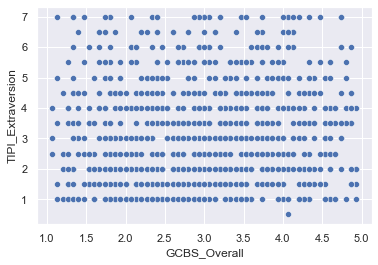

In [105]:
sns.set_theme()
sns.scatterplot(data=gcbs_clean_df, x="GCBS_Overall", y="TIPI_Extraversion")
plt.show()

### Ci sono configurazioni di personalità che nell’insieme influenzano il livello di complottismo?

#### Finding Personality types with unsupervised learning

**Domanda:** *per creare il modello di clustering posso utilizzare anche dati proveniente da altre ricerche (che usano la stessa scala) disponibili su openpsychometrics?*

**Domanda:** *Va bene k-means? La letteratura suggerisce quello come algoritmo da utilizzare ma ci sono pochi studi e recenti*

**Domanda:** *Va bene creare il modello e applicare le etichette sui dati usati per il training*

In [106]:
personality_df = gcbs_clean_df[gcbs_clean_df.filter(like='TIPI_',axis=1).columns]
personality_df

,TIPI_Extraversion,TIPI_Agreeableness,TIPI_Conscientiousness,TIPI_Emotional_Stability,TIPI_Openness
0,3.5,6.0,6.0,6.5,6.5
1,2.5,5.0,5.0,5.5,5.5
2,4.0,4.0,4.5,4.5,7.0
3,4.5,6.5,5.0,6.0,6.0
4,3.5,4.0,2.5,6.5,5.0
...,...,...,...,...,...
957,2.0,4.5,2.5,3.0,7.0
958,2.5,3.5,3.5,2.0,6.5
959,4.0,6.5,5.0,4.5,5.5
960,3.5,7.0,4.0,4.0,5.0


In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [108]:
scaler = StandardScaler()

In [109]:
scaled_array = scaler.fit_transform(personality_df)

In [110]:
scaled_dataframe = pd.DataFrame( scaled_array, columns = personality_df.columns )
scaled_dataframe.head(5)

,TIPI_Extraversion,TIPI_Agreeableness,TIPI_Conscientiousness,TIPI_Emotional_Stability,TIPI_Openness
0,0.185342,1.147371,0.978079,1.354356,0.813329
1,-0.413983,0.412504,0.329398,0.776193,-0.070265
2,0.485004,-0.322364,0.005057,0.198030,1.255126
3,0.784667,1.514805,0.329398,1.065274,0.371532
4,0.185342,-0.322364,-1.292305,1.354356,-0.512062


In [111]:
# finding the optimal number of clusters (k) with elbow and silhouette

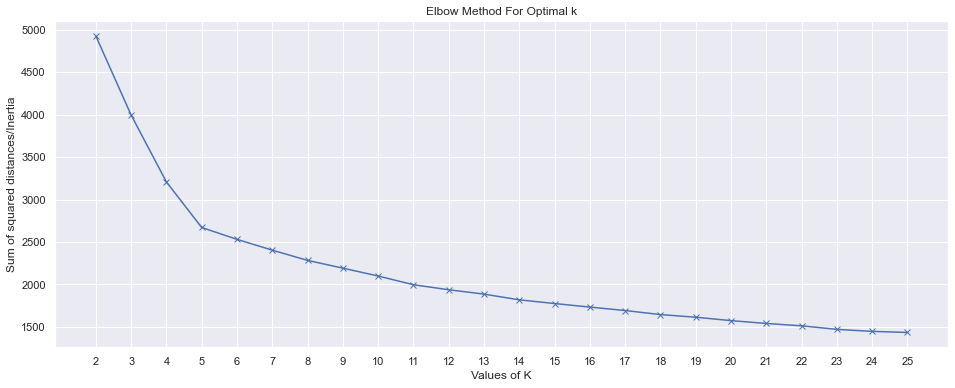

In [118]:
K = range(2,26)
sum_of_squared_distances = []
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(scaled_dataframe)
    sum_of_squared_distances.append(kmeans.inertia_)

sns.set_theme()
plt.figure(figsize=(16, 6))
plt.plot(K,sum_of_squared_distances,'bx-')
plt.xticks(K)
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

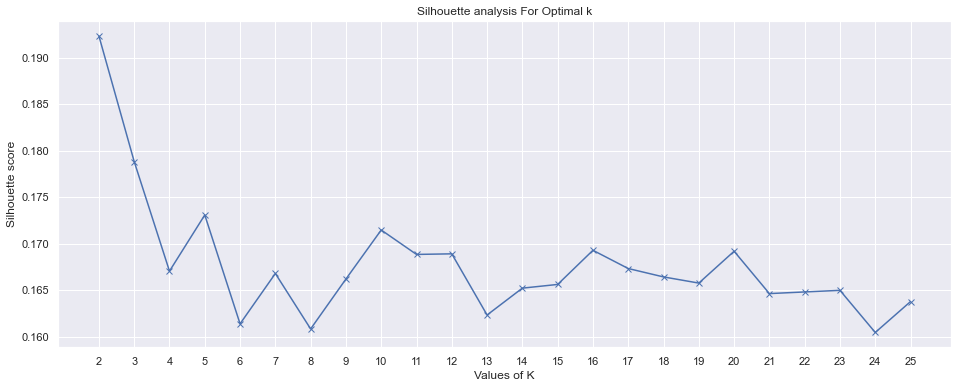

In [113]:
K = range(2,26)
silhouette_avg = []
for num_clusters in K:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(scaled_dataframe)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(scaled_dataframe, cluster_labels))
sns.set_theme()
plt.figure(figsize=(16, 6))
plt.plot(K,silhouette_avg,'bx-')
plt.xticks(K)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [119]:
kmeans_model = KMeans(n_clusters = 5)
kmeans_model.fit(scaled_dataframe)

KMeans(n_clusters=5)

In [120]:
centroids = kmeans_model.cluster_centers_
labels = kmeans_model.labels_

In [121]:
scaled_dataframe["personality_cluster"] = labels
scaled_dataframe.head(5)

,TIPI_Extraversion,TIPI_Agreeableness,TIPI_Conscientiousness,TIPI_Emotional_Stability,TIPI_Openness,personality_cluster
0,0.185342,1.147371,0.978079,1.354356,0.813329,0
1,-0.413983,0.412504,0.329398,0.776193,-0.070265,0
2,0.485004,-0.322364,0.005057,0.198030,1.255126,2
3,0.784667,1.514805,0.329398,1.065274,0.371532,0
4,0.185342,-0.322364,-1.292305,1.354356,-0.512062,3


In [122]:
scaled_dataframe.groupby(['personality_cluster']).mean()

,TIPI_Extraversion,TIPI_Agreeableness,TIPI_Conscientiousness,TIPI_Emotional_Stability,TIPI_Openness
personality_cluster,,,,,
0,0.226724,1.154370,0.706251,0.711494,0.342079
1,-0.613028,-0.217766,-0.371367,-0.565821,-1.682663
2,1.348638,0.026492,-0.379414,-0.019593,0.416208
3,-0.417276,-0.722100,0.591365,0.854023,-0.060555
4,-0.500943,-0.336773,-0.539326,-0.877807,0.374997


**Domanda:** *Faccio un grafico per confrontare le caratteristiche dei cluster?*

#### Do personality clusters influence beliefs in conspiracy theories?

In [123]:
gcbs_clean_df['TIPI_Personality_Cluster'] = labels

In [124]:
gcbs_clean_df.head(5)

,RAW_GCBS1,RAW_GCBS2,RAW_GCBS3,RAW_GCBS4,RAW_GCBS5,RAW_GCBS6,RAW_GCBS7,RAW_GCBS8,RAW_GCBS9,RAW_GCBS10,...,DEMO_familysize,DEMO_major,DEMO_major_cluster,GCBS_Overall,TIPI_Extraversion,TIPI_Agreeableness,TIPI_Conscientiousness,TIPI_Emotional_Stability,TIPI_Openness,TIPI_Personality_Cluster
0,5,5,3,5,5,5,5,3,4,5,...,1.0,Acting,Arts,4.533333,3.5,6.0,6.0,6.5,6.5,0
1,5,4,1,4,4,5,4,3,1,5,...,2.0,NaN,NaN,3.933333,2.5,5.0,5.0,5.5,5.5,0
2,5,4,3,3,4,5,5,5,5,5,...,3.0,NaN,NaN,4.400000,4.0,4.0,4.5,4.5,7.0,2
3,5,4,2,4,5,5,3,3,5,3,...,3.0,Sociology,"Literature, Language, and Social Science",3.800000,4.5,6.5,5.0,6.0,6.0,0
4,4,4,1,3,4,2,4,1,1,4,...,3.0,Religious studies,"Literature, Language, and Social Science",2.800000,3.5,4.0,2.5,6.5,5.0,3


In [125]:
pg.kruskal(data=gcbs_clean_df, dv='GCBS_Overall', between='TIPI_Personality_Cluster', detailed=False)

,Source,ddof1,H,p-unc
Kruskal,TIPI_Personality_Cluster,4,3.291704,0.510248
